## Loss landscape visualization of linear resistive networks

In [1]:
%reload_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
from spice_net import *
from helpers import *
import torch
from torch.autograd import Variable
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import itertools
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from analytic import *

In [2]:
# set Torch to use double arrays
torch.set_default_dtype(torch.double)

### Verify analytical solver gives correct results compared to SPICE baseline

In [3]:
MIN_SIZE = 5
MAX_SIZE = 40
N_TEST = 50
STRIDE = 7

in_nodes = 1
out_nodes = 1

num_pts = 40
lh = 2

for nodes in range(MIN_SIZE, MAX_SIZE+1, 7):
    for _ in range(N_TEST):
        edge_prob = np.random.uniform(0.5, 1)
        con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
        weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

        for i, (u, v) in enumerate(con_graph.edges()):
            con_graph[u][v]['type'] = 'resistor'
            con_graph[u][v]['weight'] = weights[i]

        node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
        node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
        node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

        out_plus = node_cfg[1][0][0]
        out_minus = node_cfg[1][0][1]

        net = LinearNetwork('test', con_graph, node_cfg)

        A = gen_A(net, net.inputs)
        r, M, constant_part = decomp_A(net, net.inputs)

        net_A = Analytic_net(net, net.inputs)

        # Generate target inputs
        xs = np.linspace(-lh, lh, num_pts)[:, None]
        if in_nodes > 1:
            xs= np.hstack((xs, np.ones(xs.shape)))

        # Generate target outputs
        weights = np.abs(np.random.normal(0, 0.5, size=(in_nodes, 1)))
        ys = torch.Tensor(xs @ weights)

        # generate fixed test input matrix
        X = np.zeros((nodes + in_nodes - 1, num_pts))
        X[-in_nodes:] = xs.T
        X = torch.Tensor(X)

        downsampler = make_downsampler(net)

        pred_A = np.linalg.solve(A, X).squeeze()

        A_dc = (constant_part + torch.einsum('a...,a->...', M, r)).detach().numpy()
        A_torch = net_A.constant_part + torch.einsum('a...,a->...', net_A.M, net_A.r)

        assert np.allclose(net_A.constant_part.detach().numpy(), np.array(constant_part))
        assert np.allclose(net_A.M.detach().numpy(), np.array(M))
        assert np.allclose(net_A.r.detach().numpy(), np.array(r.detach()))
        assert np.allclose(A_torch.detach().numpy(), np.array(A_dc))

        pred_dc = np.linalg.solve(A_dc, X).squeeze()

        pred_spice = net.predict(xs)

        # if needed, allow for additional room for floating-point error
        assert np.allclose(pred_A, pred_dc)
        assert np.allclose((downsampler @ pred_A).flatten(), pred_spice.flatten(), atol=1e-4)
        assert np.allclose((downsampler @ pred_dc).flatten(), pred_spice.flatten(), atol=1e-4)

print(f'Successfully validated {N_TEST * len(range(MIN_SIZE, MAX_SIZE+1, STRIDE))} test cases!')

Note: can't find the initialization file spinit.
Unsupported Ngspice version 38


Successfully validated 300 test cases!


### Set up Linear Network

In [4]:
# Fixed parameters
nodes = 8
edge_prob = 1.

in_nodes = 1
out_nodes = 1

In [5]:
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

for i, (u, v) in enumerate(con_graph.edges()):
    con_graph[u][v]['type'] = 'resistor'
    con_graph[u][v]['weight'] = weights[i]

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

out_plus = node_cfg[1][0][0]
out_minus = node_cfg[1][0][1]

net = LinearNetwork('test', con_graph, node_cfg)

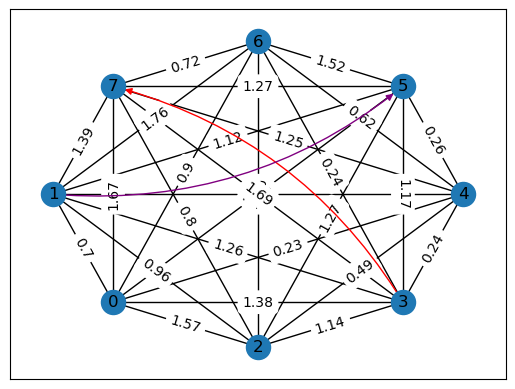

In [6]:
%matplotlib inline
visualize(net)

### Generate Data

In [7]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

In [8]:
# Generate target outputs
weights = np.abs(np.random.normal(0, 0.5, size=(2, 1)))
ys = torch.Tensor(xs_bias @ weights)

In [9]:
weights

array([[0.12891873],
       [0.38869489]])

In [13]:
# generate fixed test input matrix
# X = np.zeros((nodes + in_nodes - 1, num_pts))
# X[-in_nodes:] = xs_bias.T
X = torch.Tensor(xs)

### Initialize and train analytic network

In [72]:
# initialize network and loss function
alpha = 1.00

def make_loss_fn(analytic_net: Analytic_net, alpha):
    def loss_fn(preds, ys, t):
        return mse_loss(preds, ys) - alpha * torch.log(analytic_net.r).sum() / (t+5)
    return loss_fn

analytic_net = Analytic_net(net, net.inputs)
loss_fn = make_loss_fn(analytic_net, alpha)
downsampler = torch.Tensor(make_downsampler(net))

In [73]:
analytic_net.r

tensor([1.4199, 0.6380, 0.7246, 4.4284, 0.4924, 1.1118, 0.5994, 1.0391, 0.7941,
        0.8708, 0.8897, 0.5687, 0.7212, 0.8752, 2.0561, 0.7877, 9.5202, 1.2518,
        4.1555, 0.8575, 4.2119, 0.5931, 3.9205, 1.6060, 0.8018, 0.6596, 0.7864,
        1.3829], requires_grad=True)

In [74]:
# train the network to reach an interesting point
iters = 1000
lr = 3e2
warmup = 100
optim = torch.optim.SGD([analytic_net.r], lr=lr)
losses = []
physical_losses = []
grads = []
g_norm = []
pts = []
penalties = []

for t in range(iters):
    pts.append(analytic_net.r.detach().numpy().copy())

    preds = downsampler @ analytic_net(X)

    # loss = mse(preds, ys.T) - torch.log(r).sum() / (i+warmup)
    loss = loss_fn(preds, ys.T, t)
    physical_loss = mse_loss(preds,  ys.T)
    pen = -alpha * torch.log(analytic_net.r).sum() / (t+1)
    optim.zero_grad()
    loss.backward()
    optim.step()

    # net.update_y(-r.grad.numpy() * lr)

    grad = analytic_net.r.grad

    penalties.append(pen.detach())
    grads.append(grad.detach().numpy().copy())
    g_norm.append(torch.linalg.norm(grad))
    losses.append(loss.detach())
    physical_losses.append(physical_loss.detach())

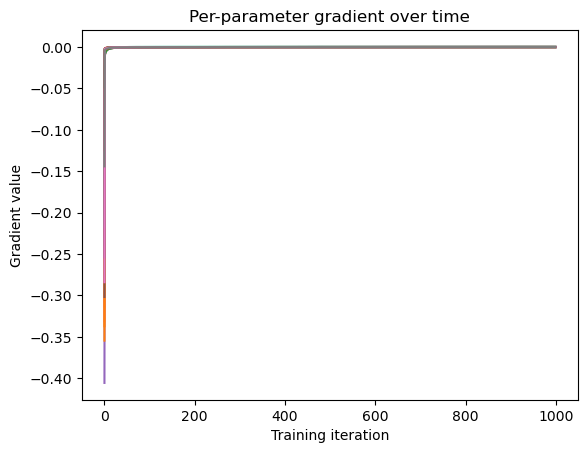

In [76]:
for l in np.array(grads).T:
    plt.plot(l)
plt.title('Per-parameter gradient over time')
plt.ylabel('Gradient value')
plt.xlabel('Training iteration')
plt.show()

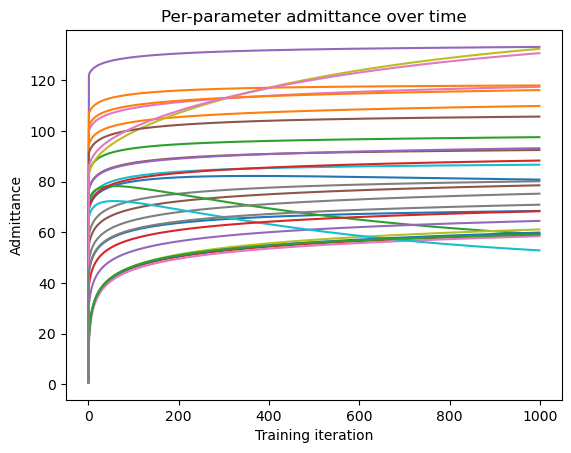

In [77]:
for l in np.array(pts).T:
    plt.plot(l)
plt.title('Per-parameter admittance over time')
plt.ylabel('Admittance')
plt.xlabel('Training iteration')
plt.show()

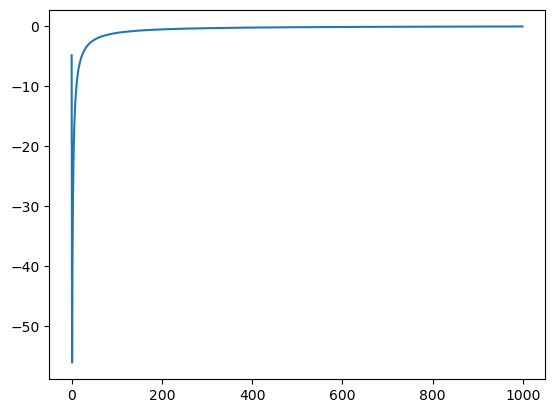

In [78]:
plt.plot(penalties)

Final loss: 0.028676706746080055


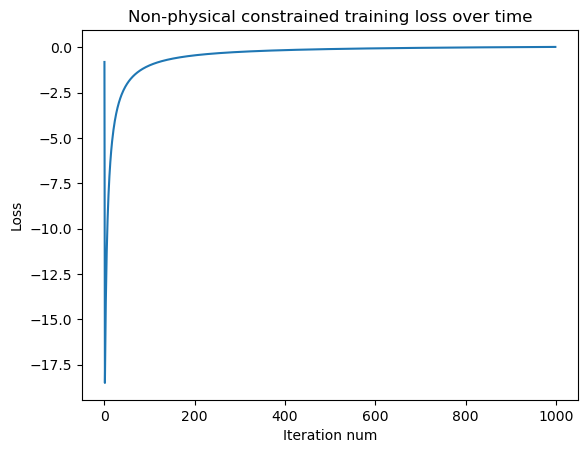

In [79]:
%matplotlib inline

ax = plt.axes(projection='rectilinear')
ax.plot(losses)
ax.set_title('Non-physical constrained training loss over time')
ax.set_xlabel('Iteration num')
ax.set_ylabel('Loss')

print(f'Final loss: {losses[-1]}')

Final loss: 0.15188075149245472


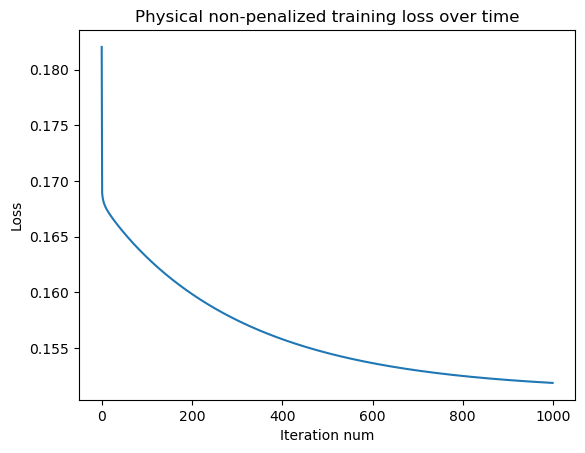

In [80]:
%matplotlib inline

ax = plt.axes(projection='rectilinear')
ax.plot(physical_losses)
ax.set_title('Physical non-penalized training loss over time')
ax.set_xlabel('Iteration num')
ax.set_ylabel('Loss')


print(f'Final loss: {physical_losses[-1]}')

Text(0, 0.5, 'Norm of gradient')

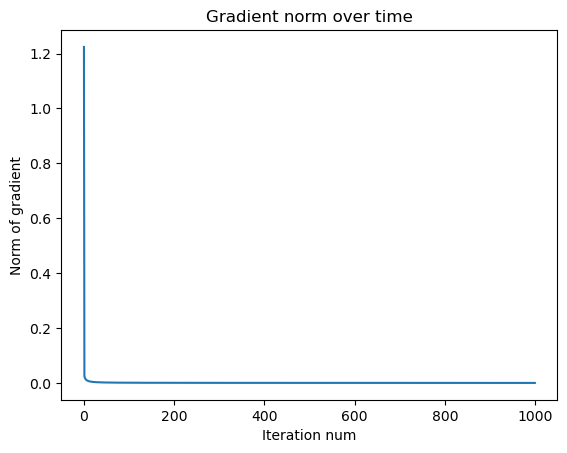

In [81]:
%matplotlib inline

ax = plt.axes(projection='rectilinear')
ax.plot(g_norm)
ax.set_title('Gradient norm over time')
ax.set_xlabel('Iteration num')
ax.set_ylabel('Norm of gradient')

### Plot loss over two particular directions

In [96]:
# choose 2 random orthogonal directions
num_edges = len(net.edges)

# d1 = torch.randn(num_edges)
# d1 /= torch.linalg.norm(d1)
# d2 = torch.randn(num_edges)
# d2 = d2 - torch.dot(d1, d2) * d1
# d2 /= torch.linalg.norm(d2)

d1 = torch.zeros(num_edges)
d2 = torch.zeros(num_edges)

d1[0] = 1
d2[1] = 1

print('Direction 1:', d1)
print('Direction 2:', d2)
print('Dot product between d1, d2:', torch.dot(d1, d2))

Direction 1: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Direction 2: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Dot product between d1, d2: tensor(0.)


In [97]:
n_sweep = 30
lh = 0.5
sweep_pts = np.linspace(-lh, lh, n_sweep)
alpha = 10

In [84]:
results = np.zeros((n_sweep, n_sweep))
x_coords, y_coords, = np.meshgrid(sweep_pts, sweep_pts)

test_net = net.copy('test')

preds = test_net.predict(xs_bias).flatten()
pt_opt = (0, 0, np.sum((preds - np.array(ys).flatten())**2)/len(preds))

orig = np.array([R.resistance for R in test_net.edges])
for x, y, (i, j) in zip(x_coords.flatten(), y_coords.flatten(), np.indices(results.shape).T.reshape((-1, 2))):
    test_net.update_y(np.array(d1*x + d2*y).flatten())

    preds = test_net.predict(xs_bias).flatten()
    loss = np.sum((preds - np.array(ys).flatten())**2)/len(preds)
    results[i, j] = loss if (1./orig + d1.numpy()*x + d2.numpy()*y > 0).all() else np.nan

    # restore weights to original values to prepare for next update
    for R, o in zip(test_net.edges, orig):
        R.resistance = o

AssertionError: Expected 1 but got 2 inputs

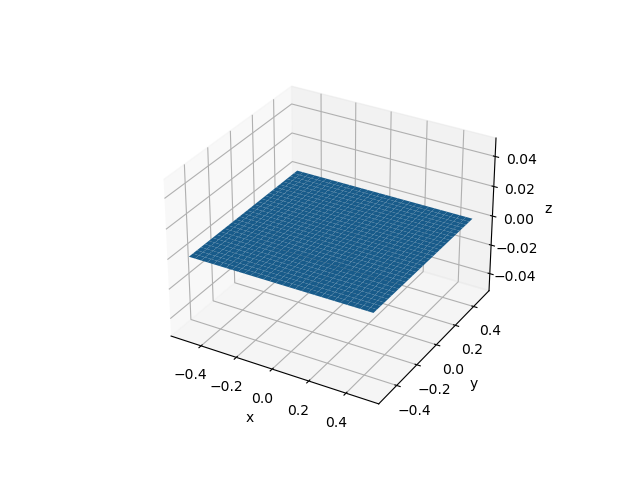

In [85]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(*pt_opt, 'ro')
ax.plot_surface(x_coords, y_coords, np.clip(results, -1, 200))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [86]:
results_a = np.zeros((n_sweep, n_sweep))
x_coords, y_coords, = np.meshgrid(sweep_pts, sweep_pts)

preds = downsampler @ torch.linalg.solve(A, X)
loss = mse(preds, ys.T) # + torch.sum(torch.maximum(-alpha*r, torch.zeros(r.shape)))
pt_opt = (0, 0, loss.detach().numpy())

for x, y, (i, j) in zip(x_coords.flatten(), y_coords.flatten(), np.indices(results.shape).T.reshape((-1, 2))):
    # rprime = torch.maximum(r + x*d1 + y*d2, torch.full(r.shape, test_net.epsilon))
    rprime = r + x*d1 + y*d2
    A = constant_part + torch.einsum('a...,a->...', M, rprime)
    preds = downsampler @ torch.linalg.solve(A, X)

    loss = mse(preds, ys.T) # + torch.sum(torch.maximum(-alpha*r, torch.zeros(r.shape)))
    results_a[i, j] = loss if (rprime > test_net.epsilon).all() else np.nan

RuntimeError: linalg.solve: Incompatible shapes of A and B for the equation AX = B (8x8 and 40x1)

In [ ]:
r.detach().numpy() + np.min(np.abs(y_coords)) * (d1.detach().numpy() + d2.detach().numpy())

array([4.13830607, 1.04197806, 0.06968539, 2.04194388, 3.51438299,
       0.60615472, 1.18235136, 1.43983629, 0.10757469, 1.69451385,
       1.9393927 , 2.18653072, 1.33335781, 0.45633922, 1.04721785,
       1.0234054 , 2.5205017 , 0.97226732, 0.43751591, 0.30259252,
       3.75511556, 1.16863581, 1.07639322, 1.85934712, 1.12193791,
       0.40059109, 1.23749025, 0.85845411])

In [ ]:
r

tensor([4.1324, 1.0426, 0.0653, 2.0503, 3.5210, 0.6092, 1.1777, 1.4402, 0.1051,
        1.6964, 1.9421, 2.1833, 1.3399, 0.4549, 1.0425, 1.0122, 2.5176, 0.9729,
        0.4397, 0.2991, 3.7616, 1.1613, 1.0742, 1.8606, 1.1274, 0.3973, 1.2347,
        0.8596], requires_grad=True)

In [ ]:
valid = np.zeros((n_sweep, n_sweep))

for x, y, (i, j) in zip(x_coords.flatten(), y_coords.flatten(), np.indices(results.shape).T.reshape((-1, 2))):
    # rprime = torch.maximum(r + x*d1 + y*d2, torch.full(r.shape, test_net.epsilon))
    rprime = r + x*d1 + y*d2
    valid[i, j] = (rprime >= test_net.epsilon).all()

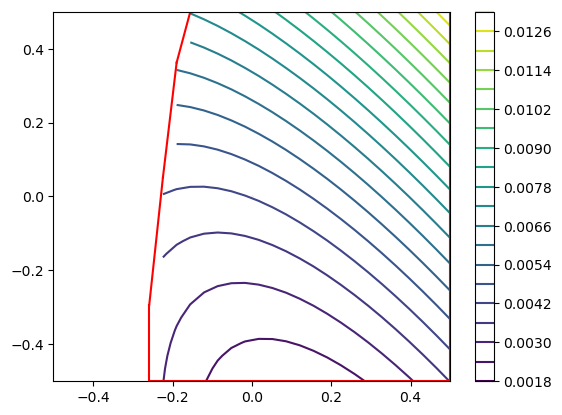

In [ ]:
%matplotlib inline
x_coords, y_coords, = np.meshgrid(sweep_pts, sweep_pts)

fig = plt.figure()
ax = plt.axes(projection='rectilinear')
# ax = plt.axes(projection='3d')
# ax.plot_surface(x_coords, y_coords, np.clip(results_a, -1, 1))
lines = ax.contour(x_coords, y_coords, np.clip(results_a, -1, 1), 20)
valid_idx = np.nonzero(valid > 0)
valid_pts = np.stack([x_coords[valid_idx], y_coords[valid_idx]]).T
hull = ConvexHull(valid_pts)
# ax.plot(valid_pts[hull.vertices,0], valid_pts[hull.vertices,1], 'r--', lw=2)
for simplex in hull.simplices:
    ax.plot(valid_pts[simplex, 0], valid_pts[simplex, 1], 'r-')
plt.colorbar(lines)
ax.scatter(*pt_opt, c='r')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
plt.show()

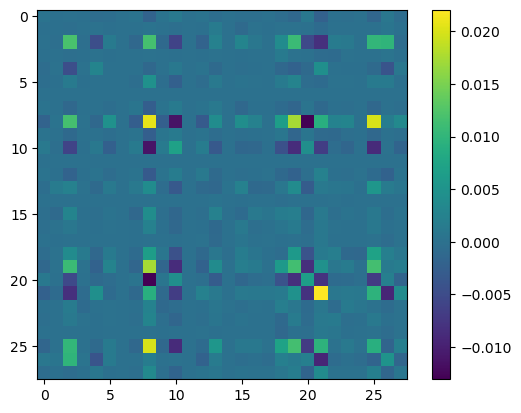

In [ ]:
%matplotlib inline

ax = plt.axes(projection='rectilinear')
hess = torch.autograd.functional.hessian(lambda r: mse(downsampler @ torch.linalg.solve(constant_part + torch.einsum('a...,a->...', M, r), X), ys.T), rprime)
im = ax.imshow(hess)
plt.colorbar(im)

### PCA on significant descent directions

In [87]:
# cut out the first few training points because the loss landscape is significantly changed bythe barrier method
cutoff = 1
diffs = np.stack([pt - pts[-1] for pt in pts[cutoff:-1]])

In [88]:
diffs.shape

(998, 28)

In [89]:
pca = PCA(2)
pca.fit(pts)

PCA(n_components=2)

In [90]:
pca.explained_variance_ratio_

array([0.865753  , 0.11558736])

In [91]:
pts[0]

array([1.41993656, 0.63801704, 0.72458132, 4.42835598, 0.49236498,
       1.11177836, 0.59935014, 1.0391069 , 0.79409142, 0.87081681,
       0.88973768, 0.56872725, 0.72118332, 0.87518701, 2.05612149,
       0.78769095, 9.52021183, 1.25177868, 4.15551781, 0.85748808,
       4.21191654, 0.59311143, 3.92048048, 1.6060373 , 0.80180976,
       0.6595854 , 0.78644366, 1.38285455])

In [92]:
pts[[0, -1]]

TypeError: list indices must be integers or slices, not list

In [100]:
coords_stack = np.stack(x_coords.flatten(), y_coords.flatten())

TypeError: only integer scalar arrays can be converted to a scalar index

In [145]:
D = np.vstack((d1, d2))
D

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [146]:
n_sweep = 100
xmin, xmax = -5, 20
ymin, ymax = -2, 3
epsilon = net.epsilon
r_star = analytic_net.r.detach()
M = analytic_net.M.detach()
constant_part = analytic_net.constant_part.detach()

results_a = np.zeros((n_sweep, n_sweep))

# p_init, p_star = pca.transform(pts[[0, -1]])
x_coords, y_coords, = np.meshgrid(*np.linspace([xmin, ymin], [xmax, ymax], n_sweep).T)


A = constant_part + torch.einsum('a...,a->...', M, r_star)
preds = downsampler @ solve_torch(A, X)
loss = loss_fn(preds, ys.T, 1000) 
pt_opt = (0, 0, loss.detach().numpy())

for x, y, (i, j) in zip(x_coords.flatten(), y_coords.flatten(), np.indices(results_a.shape).T.reshape((-1, 2))):
    # r_prime = torch.Tensor(pca.inverse_transform([x, y]) - pca.mean_) + r_star
    r_prime = r_star + d1*x + d2*y
    A = constant_part + torch.einsum('a...,a->...', M, r_prime)
    preds = downsampler @ solve_torch(A, X)

    loss = loss_fn(preds, ys.T, 1000) #- torch.log(rprime).sum() / (i+1)
    results_a[i, j] = loss if (r_prime > epsilon).all() else np.nan

In [156]:
trajectory = pts[5:,:2]

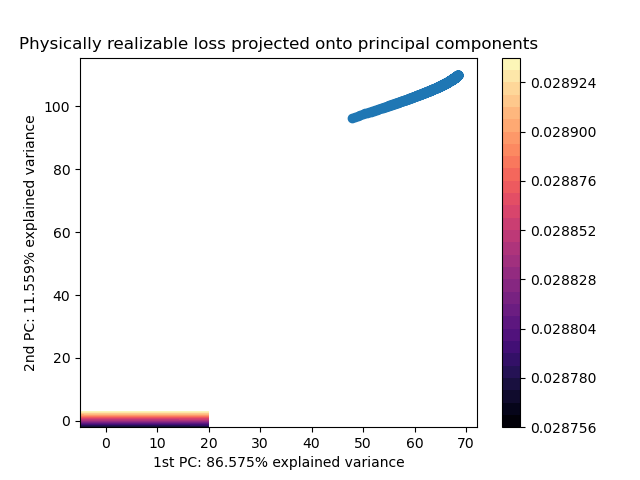

In [157]:
fig = plt.figure()
pts = np.array(pts)
ax = plt.axes(projection='rectilinear')
lines = ax.contourf(x_coords, y_coords, results_a, 30, cmap='magma')
plt.colorbar(lines)
ax.set_xlabel(f'1st PC: {pca.explained_variance_ratio_[0]*100:.3f}% explained variance')
ax.set_ylabel(f'2nd PC: {pca.explained_variance_ratio_[1]*100:.3f}% explained variance')
# ax.plot(*(np.dot(np.stack(diffs)[cutoff:], pca.components_.T)).T) # follows from paper's implementation -- wrong?
# ax.scatter(*pca.transform(pts).T) 
ax.scatter(*trajectory.T) 
# ax.scatter(*p_star.T, c='cyan') # optimum point is always (0, 0)
ax.set_title('Physically realizable loss projected onto principal components')

plt.show()

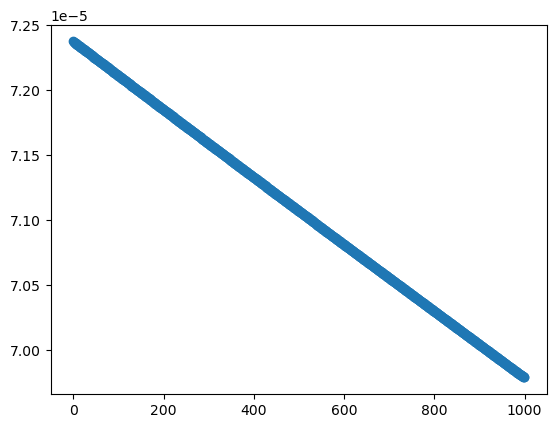

In [55]:
plt.plot([np.linalg.norm(g) for g in grads], 'o')

In [38]:
grads[1] - pca.mean_

NameError: name 'pca' is not defined

In [39]:
plt.plot([np.dot(x - pca.mean_, y - pca.mean_) / (np.linalg.norm(x - pca.mean_)*np.linalg.norm(y - pca.mean_)) for x, y in zip(grads[1:], grads[:-1])])

NameError: name 'pca' is not defined

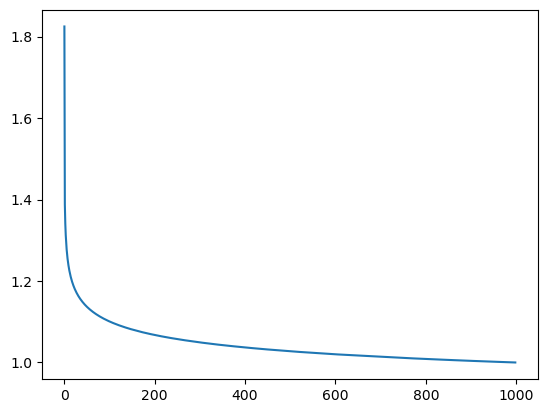

In [148]:
plt.plot([np.dot(x, pts[-1]) / (np.linalg.norm(x)*np.linalg.norm(y)) for x, y in zip(pts[1:], pts[:-1])])